In [3]:
# %%
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import yaml
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append("..")

from data import raw
from typing import Iterator, Tuple
import torch
from torch.utils.data import Dataset, DataLoader
import importlib
# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
importlib.reload(raw)  # force reload most recent version


<module 'data.raw' from 'c:\\Users\\Francisco Cardoso\\OneDrive\\Ambiente de Trabalho\\Projects\\Volatility Forecasting\\notebooks\\..\\data\\raw.py'>

c:\Users\Francisco Cardoso\OneDrive\Ambiente de Trabalho\Projects\Volatility Forecasting\notebooks\..\data\raw.py:26: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df=yf.download(list(tickers.keys()),start=start_date,end=end_date)
[*********************100%***********************]  3 of 3 completed


Final data shape after feature engineering: (57, 10)
Data period: 2025-04-30 00:00:00 to 2025-07-22 00:00:00


C:\Users\Francisco Cardoso\AppData\Local\Temp\ipykernel_10504\1315691633.py:102: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.

C:\Users\Francisco Cardoso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.



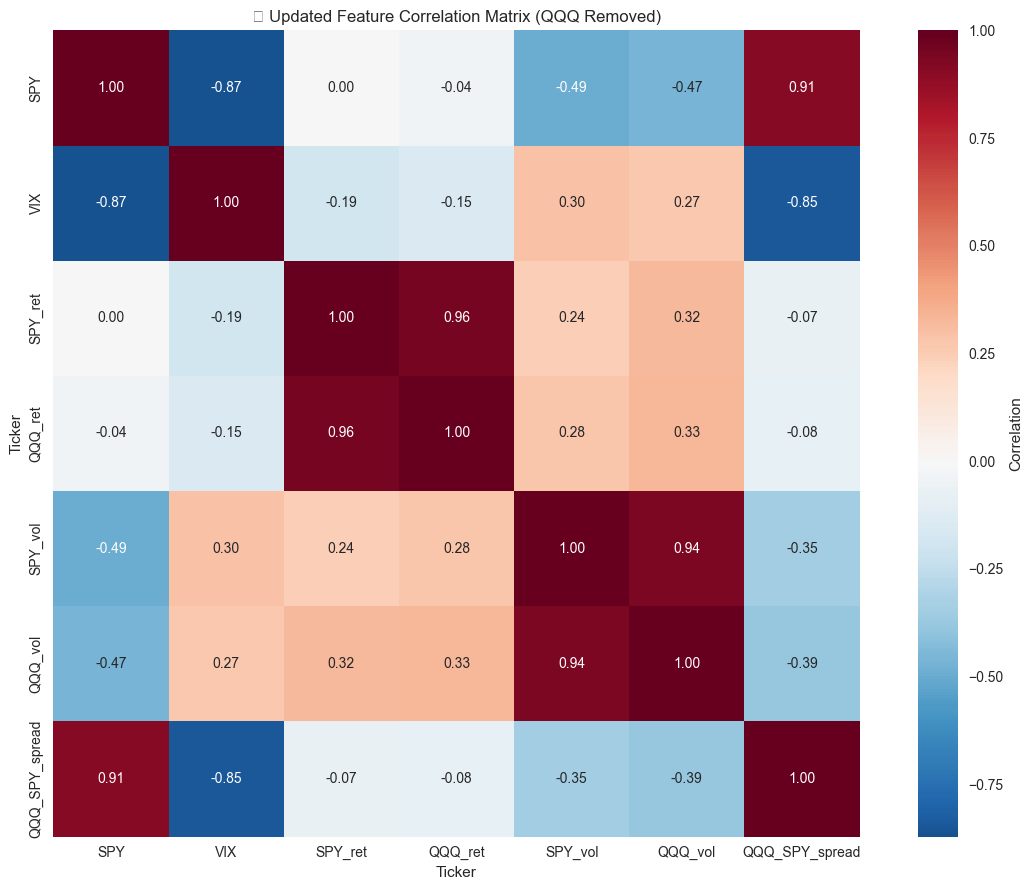

C:\Users\Francisco Cardoso\AppData\Local\Temp\ipykernel_10504\1315691633.py:109: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.

C:\Users\Francisco Cardoso\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\IPython\core\pylabtools.py:170: UserWarning:

Glyph 128279 (\N{LINK SYMBOL}) missing from font(s) Arial.



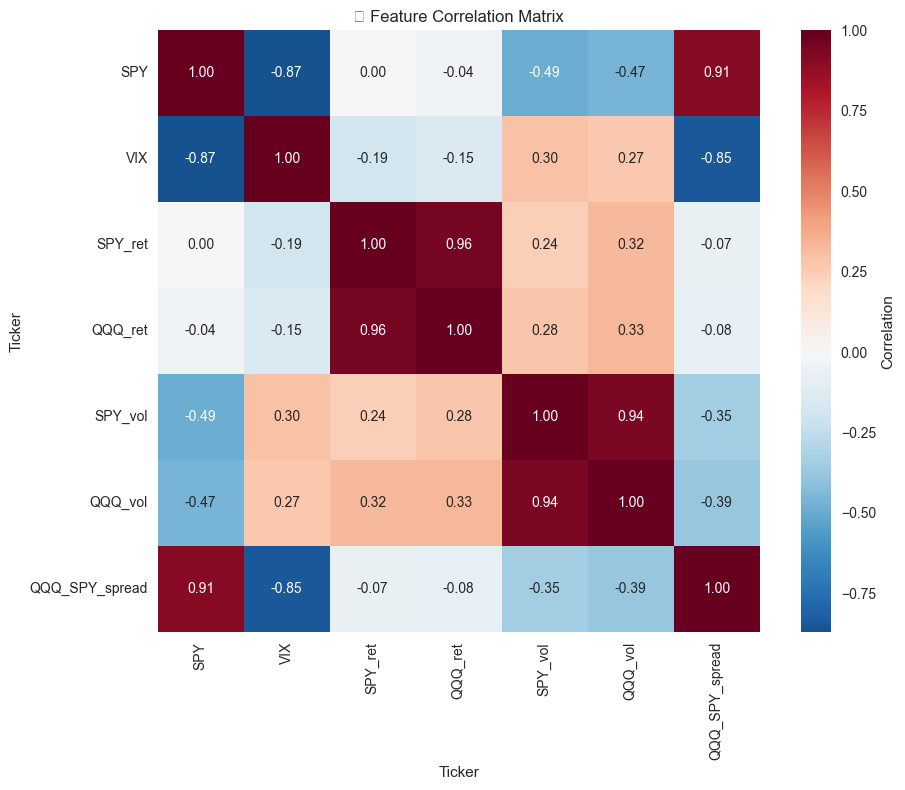

In [4]:



# %%

data=raw.download_fin_data(raw.tickers,90)
data

# %%
try:
    data['VIX_ret'] = data['^VIX'].pct_change()
except KeyError:
    print("VIX column not found.")

# Compute returns
data['SPY_ret'] = data['SPY'].pct_change()
data['QQQ_ret'] = data['QQQ'].pct_change()

# Compute rolling volatility
data['SPY_vol'] = data['SPY_ret'].rolling(window=5).std()
data['QQQ_vol'] = data['QQQ_ret'].rolling(window=5).std()

# ===== IMPROVED FEATURE ENGINEERING =====
# Remove redundancy: QQQ and SPY are 1.00 correlated, keep SPY only
# Add spread feature to capture relative performance
data['QQQ_SPY_spread'] = (data['QQQ'] - data['SPY']) / data['SPY']  # Normalized spread





# Rename ^VIX to VIX if needed
data = data.rename(columns={"^VIX": "VIX"})

# Drop all NaNs from above steps
data = data.dropna()

# Create vix_signal safely
vix_future_change = data['VIX'].pct_change().shift(-1)
vix_signal = pd.cut(vix_future_change, bins=[-np.inf, -0.01, 0.01, np.inf], labels=[0, 1, 2])

# Assign using nullable integer dtype (safe even with missing values)
data['vix_signal'] = vix_signal.astype('Int64')

# Updated feature set (removed QQQ, added spread)
feature_cols = ['SPY', 'VIX', 'SPY_ret', 'QQQ_ret', 'SPY_vol', 'QQQ_vol', 'QQQ_SPY_spread']
target_col = 'vix_signal'

# Final check
print(f"Final data shape after feature engineering: {data.shape}")
print(f"Data period: {data.index[0]} to {data.index[-1]}")

# %%
# ===== VISUALIZATION 1: Raw Data Overview =====
def plot_raw_data_overview(data):
    fig = make_subplots(
        rows=4, cols=1,
        subplot_titles=['Asset Prices', 'Returns', 'Volatility', 'VIX Signals'],
        vertical_spacing=0.08,
        row_heights=[0.3, 0.25, 0.25, 0.2]
    )
    
    # Asset Prices
    fig.add_trace(go.Scatter(x=data.index, y=data['QQQ'], name='QQQ', line=dict(color='blue')), row=1, col=1)
    fig.add_trace(go.Scatter(x=data.index, y=data['SPY'], name='SPY', line=dict(color='green')), row=1, col=1)
    fig.add_trace(go.Scatter(x=data.index, y=data['VIX'], name='VIX', line=dict(color='red'), yaxis='y2'), row=1, col=1)
    
    # Returns
    fig.add_trace(go.Scatter(x=data.index, y=data['QQQ_ret']*100, name='QQQ Returns %', line=dict(color='blue')), row=2, col=1)
    fig.add_trace(go.Scatter(x=data.index, y=data['SPY_ret']*100, name='SPY Returns %', line=dict(color='green')), row=2, col=1)
    
    # Volatility
    fig.add_trace(go.Scatter(x=data.index, y=data['QQQ_vol']*100, name='QQQ Vol %', line=dict(color='blue')), row=3, col=1)
    fig.add_trace(go.Scatter(x=data.index, y=data['SPY_vol']*100, name='SPY Vol %', line=dict(color='green')), row=3, col=1)
    
    # VIX Signals
    colors = ['red', 'yellow', 'green']
    for i, signal in enumerate([0, 1, 2]):
        signal_data = data[data['vix_signal'] == signal]
        fig.add_trace(go.Scatter(
            x=signal_data.index, 
            y=[signal]*len(signal_data), 
            mode='markers',
            name=f'VIX Signal {signal}',
            marker=dict(color=colors[i], size=8)
        ), row=4, col=1)
    
    fig.update_layout(height=800, title="📊 Financial Data Overview")
    fig.show()

plot_raw_data_overview(data)

# %%
# ===== VISUALIZATION 2: Correlation Heatmap =====
def plot_correlation_matrix(data):

    # Updated numerical columns (removed QQQ, added spread)
    numeric_cols = ['SPY', 'VIX', 'SPY_ret', 'QQQ_ret', 'SPY_vol', 'QQQ_vol', 'QQQ_SPY_spread']
    corr_matrix = data[numeric_cols].corr()
    
    plt.figure(figsize=(12, 9))  # Slightly larger for new feature
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, fmt='.2f', cbar_kws={'label': 'Correlation'})
    plt.title('🔗 Updated Feature Correlation Matrix (QQQ Removed)')
    plt.tight_layout()
    plt.show()    
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
                square=True, fmt='.2f', cbar_kws={'label': 'Correlation'})
    plt.title('🔗 Feature Correlation Matrix')
    plt.tight_layout()
    plt.show()

plot_correlation_matrix(data)

# %%
# ===== VISUALIZATION 3: VIX Signal Distribution =====
def plot_vix_signal_analysis(data):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Signal distribution
    signal_counts = data['vix_signal'].value_counts().sort_index()
    ax1.bar(['Down (0)', 'Neutral (1)', 'Up (2)'], signal_counts.values, 
            color=['red', 'yellow', 'green'], alpha=0.7)
    ax1.set_title('VIX Signal Distribution')
    ax1.set_ylabel('Count')
    
    # Signal over time
    ax2.scatter(data.index, data['vix_signal'], c=data['vix_signal'], 
                cmap='RdYlGn', alpha=0.6, s=50)
    ax2.set_title('VIX Signals Over Time')
    ax2.set_ylabel('Signal (0=Down, 1=Neutral, 2=Up)')
    
    # VIX vs Signal
    for signal in [0, 1, 2]:
        signal_data = data[data['vix_signal'] == signal]
        ax3.scatter(signal_data['VIX'], signal_data['vix_signal'] + np.random.normal(0, 0.05, len(signal_data)), 
                   alpha=0.6, label=f'Signal {signal}')
    ax3.set_xlabel('VIX Level')
    ax3.set_ylabel('Signal')
    ax3.set_title('VIX Level vs Signal')
    ax3.legend()
    
    # Volatility vs Signal
    data.boxplot(column='QQQ_vol', by='vix_signal', ax=ax4)
    ax4.set_title('QQQ Volatility by VIX Signal')
    ax4.set_xlabel('VIX Signal')
    ax4.set_ylabel('QQQ Volatility')
    
    plt.tight_layout()
    plt.show()



